In [4]:
#k-means 

In [5]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [8]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

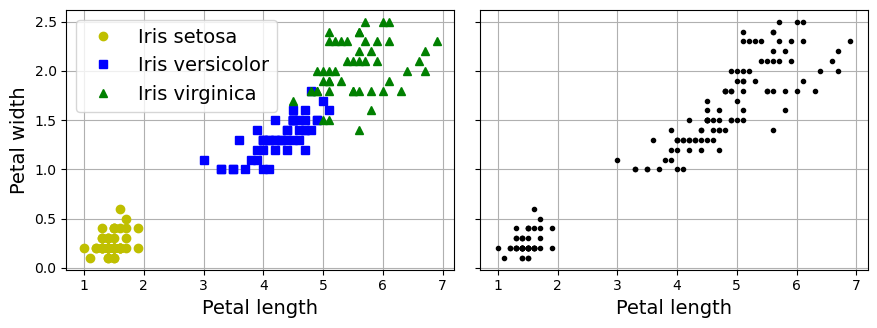

In [9]:

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

save_fig("classification_vs_clustering_plot")
plt.show()

In [10]:
#using clustering for image classification

In [11]:
import urllib.request

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [12]:
import PIL 
image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

In [13]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

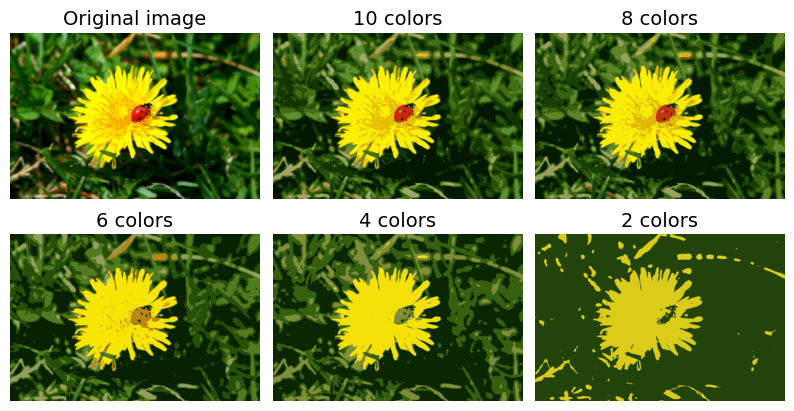

In [14]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

save_fig('image_segmentation_plot', tight_layout=False)
plt.show()

In [15]:
#pip install threadpoolctl==3.1.0

In [16]:
#clusterin for semi-supervised learning

In [17]:
from sklearn.datasets import load_digits

In [18]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [21]:
log_reg.score(X_test, y_test)

0.7481108312342569

In [22]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.906801007556675

In [23]:
k = 50 
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digits_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digits_idx]

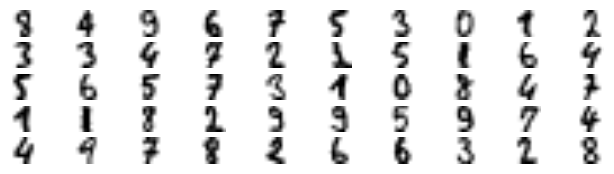

In [24]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [25]:
y_representative_digits = np.array([
    8,4,9,6,7,5,3,0,1,2,
    3, 3,4,7,2, 1,5, 1 ,6,4,
    5,6,5,7,3, 1,0,8,4,7,
    1,1,8,8,2,9,5,9,7,4,
    4,9,7,8,2,6,6,3,2,8
    
])

In [26]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.801007556675063

In [27]:
y_train_propogated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propogated[kmeans.labels_ == i] = y_representative_digits[i]

In [28]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propogated)

LogisticRegression(max_iter=10000)

In [29]:
log_reg.score(X_test, y_test)

0.7682619647355163

In [30]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propogated[partially_propagated]

In [31]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.7884130982367759

In [32]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9081481481481481

In [33]:
#DBSCAN

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [35]:
X, y = make_moons(n_samples=1000, noise=0.05)

In [36]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [37]:
dbscan.labels_

array([11,  0,  1,  1,  2,  3,  0, -1,  0,  0,  0,  0,  4,  0, 11,  8,  5,
        6, -1,  1,  0,  0,  0,  4,  1,  3,  7,  8, 11,  6,  4,  0,  5,  0,
       -1,  4,  4,  1, -1,  3,  2, -1,  1,  0, -1,  4, -1,  0,  1,  4,  1,
        1,  8,  0,  9,  1,  5,  1,  1,  0,  3,  0,  2,  0,  1,  2, -1,  0,
        4,  0,  1,  1,  4,  1,  7,  9,  4,  2,  9,  0,  0,  0,  0,  0, -1,
        2,  4, -1,  1,  2,  2,  4,  1,  0, -1,  2,  1,  9,  3,  0,  1,  0,
        2,  3,  1,  4,  1,  4,  0,  4,  1, 11,  2,  4, -1,  4,  1,  1,  0,
        1,  1,  7,  4, 12,  1,  1,  2,  5,  4,  0,  0,  1,  9,  1,  6,  1,
        9,  0,  0, -1,  1,  3,  2,  6,  1,  4, -1,  4,  4,  1,  7,  6, 10,
        0,  1,  1,  2, -1,  0,  4,  1,  1,  3, -1,  0,  4,  2,  1, 10,  9,
        2,  1,  4,  1,  0,  1,  6,  5,  1,  1,  1,  0,  9,  4, -1,  4, 11,
        1,  0,  2,  1,  0,  0,  4,  0,  3, -1,  5,  4,  0,  0,  1,  2,  1,
        5,  0,  4,  4,  1,  3,  3,  1,  0,  8,  6,  7,  5, -1,  3,  5,  8,
        7,  3,  2,  6,  4

In [38]:
dbscan.core_sample_indices_

array([  1,   2,   4,   5,   8,   9,  10,  11,  12,  16,  17,  19,  20,
        21,  22,  23,  24,  25,  26,  29,  30,  31,  33,  35,  36,  37,
        39,  40,  42,  43,  45,  47,  48,  49,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  61,  65,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  79,  81,  82,  83,  86,  88,  89,  90,  91,  92,
        93,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105, 107, 108,
       109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 141,
       142, 143, 144, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156,
       158, 159, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174,
       175, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 188, 189,
       190, 191, 193, 194, 197, 198, 199, 200, 201, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 23

In [39]:
dbscan.components_

array([[ 6.42431989e-01, -4.63063438e-01],
       [ 7.34720654e-02,  9.90632242e-01],
       [-8.94735396e-01,  4.83500786e-01],
       ...,
       [-1.17839920e-03,  4.04106901e-01],
       [-6.57985658e-01,  8.11216027e-01],
       [ 2.02697289e+00,  4.56767224e-01]])

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [42]:
X_new = np.array([[-0.5,0], [0,0.5], [1,-0.1], [2,1]])
knn.predict(X_new)

array([ 2,  0,  7, 10], dtype=int64)

In [43]:
knn.predict_proba(X_new)

array([[0.14, 0.  , 0.7 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.16, 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.26, 0.  , 0.  , 0.  , 0.72, 0.  , 0.  , 0.  ,
        0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.  , 0.  , 0.32, 0.  , 0.42,
        0.  , 0.  ]])

In [44]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1

In [45]:
y_pred.ravel()

array([-1,  0,  7, -1], dtype=int64)